In [1]:
import os

In [2]:
os.getcwd()

'/work/ia024/trabalho_final/rome/notebooks'

# Script to plot average causal effects

This script loads sets of hundreds of causal traces that have been computed by the
`experiment.causal_trace` program, and then aggregates the results to compute
Average Indirect Effects and Average Total Effects as well as some other information.


In [3]:
import numpy, os
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# Uncomment the architecture to plot.

# arch = "gpt2-xl"
# archname = "GPT-2-XL"

# arch = 'EleutherAI_gpt-j-6B'
# archname = 'GPT-J-6B'

# arch = 'EleutherAI_gpt-neox-20b'
# archname = 'GPT-NeoX-20B'

arch = "ns3_r0_microsoft_phi-1_5"
archname = "microsoft phi 1.5"

class Avg:
    def __init__(self):
        self.d = []

    def add(self, v):
        self.d.append(v[None])

    def add_all(self, vv):
        self.d.append(vv)

    def avg(self):
        return numpy.concatenate(self.d).mean(axis=0)

    def std(self):
        return numpy.concatenate(self.d).std(axis=0)

    def size(self):
        return sum(datum.shape[0] for datum in self.d)

In [72]:
def read_knowlege(count=150, kind=None, arch="gpt2-xl"):
    dirname = f"../results/{arch}/causal_trace/cases/"
    kindcode = "" if not kind else f"_{kind}"
    (
        avg_fe,
        avg_ee,
        avg_le,
        avg_fa,
        avg_ea,
        avg_la,
        avg_hs,
        avg_ls,
        avg_fs,
        avg_fle,
        avg_fla,
    ) = [Avg() for _ in range(11)]

    ignored_results = 0
    
    for i in range(count):
        try:
            data = numpy.load(f"{dirname}/knowledge_{i}{kindcode}.npz")        
        except:
            continue
        # Only consider cases where the model begins with the correct prediction
        if "correct_prediction" in data and not data["correct_prediction"]:
            ignored_results += 1
            continue
        scores = data["scores"]

        first_e, first_a = data["subject_range"]
        last_e = first_a - 1
        last_a = len(scores) - 1
        # original prediction
        avg_hs.add(data["high_score"])
        # prediction after subject is corrupted
        avg_ls.add(data["low_score"])
        avg_fs.add(scores.max())
        # some maximum computations
        avg_fle.add(scores[last_e].max())
        avg_fla.add(scores[last_a].max())
        # First subject middle, last subjet.
        avg_fe.add(scores[first_e])
        avg_ee.add_all(scores[first_e + 1 : last_e])
        avg_le.add(scores[last_e])
        # First after, middle after, last after
        avg_fa.add(scores[first_a])
        avg_ea.add_all(scores[first_a + 1 : last_a])
        avg_la.add(scores[last_a])

    result = numpy.stack(
        [
            avg_fe.avg(),
            avg_ee.avg(),
            avg_le.avg(),
            avg_fa.avg(),
            avg_ea.avg(),
            avg_la.avg(),
        ]
    )
    result_std = numpy.stack(
        [
            avg_fe.std(),
            avg_ee.std(),
            avg_le.std(),
            avg_fa.std(),
            avg_ea.std(),
            avg_la.std(),
        ]
    )
    print("Average Total Effect", avg_hs.avg() - avg_ls.avg())
    print(
        "Best average indirect effect on last subject",
        avg_le.avg().max() - avg_ls.avg(),
    )
    print(
        "Best average indirect effect on last token", avg_la.avg().max() - avg_ls.avg()
    )
    print("Average best-fixed score", avg_fs.avg())
    print("Average best-fixed on last subject token score", avg_fle.avg())
    print("Average best-fixed on last word score", avg_fla.avg())
    print("Argmax at last subject token", numpy.argmax(avg_le.avg()))
    print("Max at last subject token", numpy.max(avg_le.avg()))
    print("Argmax at last prompt token", numpy.argmax(avg_la.avg()))
    print("Max at last prompt token", numpy.max(avg_la.avg()))

    print("\n\nIgnored results: {}".format(ignored_results))
    
    return dict(
        low_score=avg_ls.avg(), 
        result=result, 
        result_std=result_std, 
        size=avg_fe.size(), 
        last_subject_data=numpy.array(avg_le.d).squeeze() - numpy.array(avg_ls.d)
    )

In [73]:
def plot_array(
    differences,
    kind=None,
    savepdf=None,
    title=None,
    low_score=None,
    high_score=None,
    archname="GPT2-XL",
):
    if low_score is None:
        low_score = differences.min()
    if high_score is None:
        high_score = differences.max()
    answer = "AIE"
    labels = [
        "First subject token",
        "Middle subject tokens",
        "Last subject token",
        "First subsequent token",
        "Further tokens",
        "Last token",
    ]

    fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
    h = ax.pcolor(
        differences,
        cmap={None: "Purples", "mlp": "Greens", "attn": "Reds"}[kind],
        vmin=low_score,
        vmax=high_score,
    )
    if title:
        ax.set_title(title)
    ax.invert_yaxis()
    ax.set_yticks([0.5 + i for i in range(len(differences))])
    ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
    ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
    ax.set_yticklabels(labels)
    if kind is None:
        ax.set_xlabel(f"single patched layer within {archname}")
    else:
        ax.set_xlabel(f"center of interval of 10 patched {kind} layers")
    cb = plt.colorbar(h)
    # The following should be cb.ax.set_xlabel(answer), but this is broken in matplotlib 3.5.1.
    if answer:
        cb.ax.set_title(str(answer).strip(), y=-0.16, fontsize=10)

    if savepdf:
        os.makedirs(os.path.dirname(savepdf), exist_ok=True)
        plt.savefig(savepdf, bbox_inches="tight")
    plt.show()

Average Total Effect 0.42550782211353866
Best average indirect effect on last subject 0.15800627418091384
Best average indirect effect on last token 0.4255079115205058
Average best-fixed score 0.48769975
Average best-fixed on last subject token score 0.24290925
Average best-fixed on last word score 0.48217574
Argmax at last subject token 4
Max at last subject token 0.20896398
Argmax at last prompt token 23
Max at last prompt token 0.4764656


Ignored results: 718


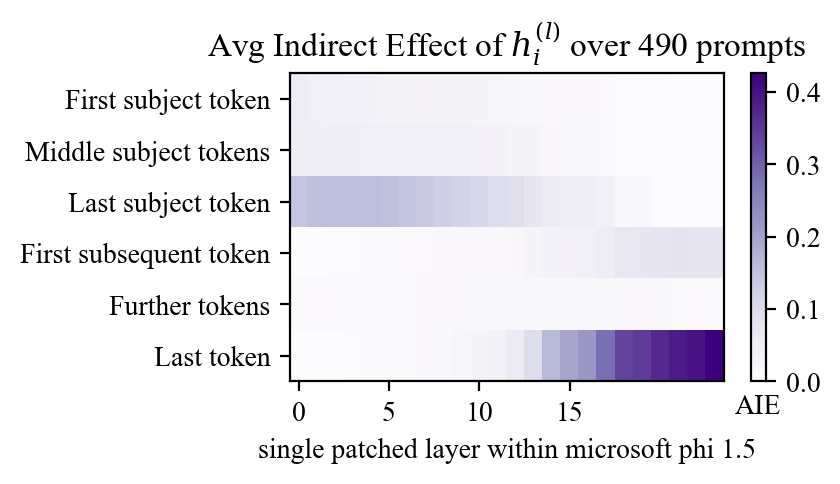

Average Total Effect 0.42550782211353866
Best average indirect effect on last subject 0.15240100868275253
Best average indirect effect on last token 0.04543633111050217
Average best-fixed score 0.29666826
Average best-fixed on last subject token score 0.22023599
Average best-fixed on last word score 0.109784015
Argmax at last subject token 5
Max at last subject token 0.20335871
Argmax at last prompt token 16
Max at last prompt token 0.09639403


Ignored results: 718


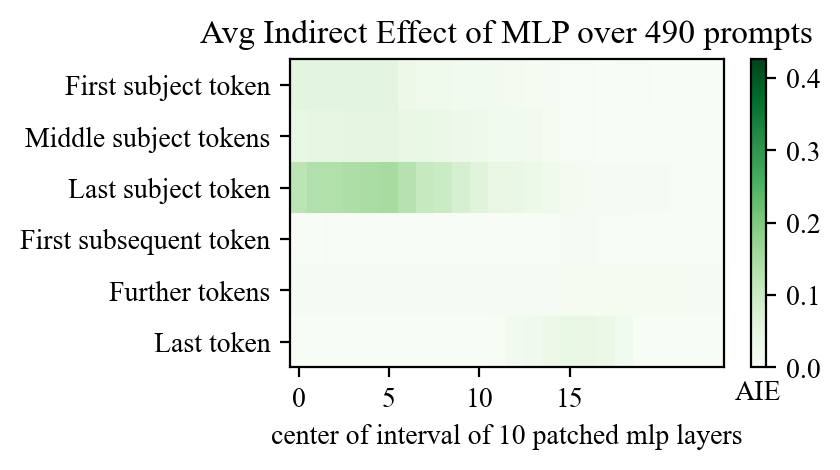

Average Total Effect 0.42550782211353866
Best average indirect effect on last subject 0.11860013850262253
Best average indirect effect on last token 0.28187320478489486
Average best-fixed score 0.37602273
Average best-fixed on last subject token score 0.18271089
Average best-fixed on last word score 0.36543018
Argmax at last subject token 5
Max at last subject token 0.16955784
Argmax at last prompt token 14
Max at last prompt token 0.3328309


Ignored results: 718


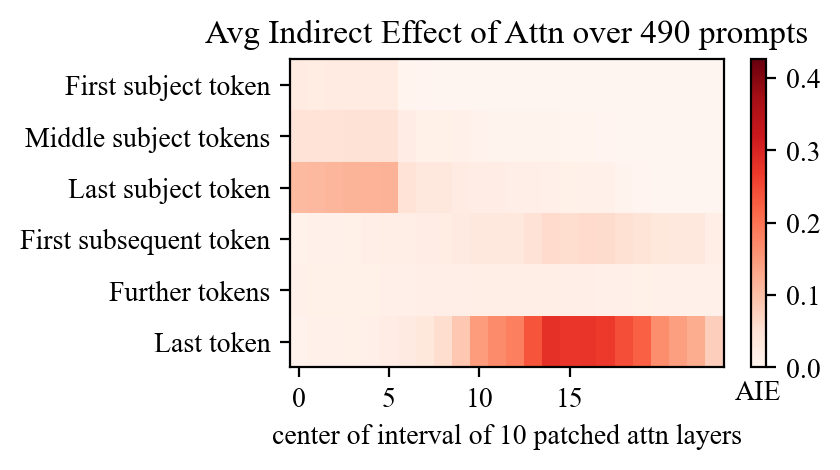

In [74]:
the_count = 1208
high_score = None  # Scale all plots according to the y axis of the first plot

computed_scores={}

for kind in [None, "mlp", "attn"]:
    d = read_knowlege(the_count, kind, arch)
    count = d["size"]
    what = {
        None: "Indirect Effect of $h_i^{(l)}$",
        "mlp": "Indirect Effect of MLP",
        "attn": "Indirect Effect of Attn",
    }[kind]
    title = f"Avg {what} over {count} prompts"
    result = numpy.clip(d["result"] - d["low_score"], 0, None)
    kindcode = "" if kind is None else f"_{kind}"
    if kind not in ["mlp", "attn"]:
        high_score = result.max()
        computed_scores['entire_layer'] = d
    else:
        computed_scores[kind] =  d
    
    plot_array(
        result,
        kind=kind,
        title=title,
        low_score=0.0,
        high_score=high_score,
        archname=archname,
        savepdf=f"results/{arch}/causal_trace/summary_pdfs/rollup{kindcode}.pdf",
    )

In [67]:
computed_scores.keys()

dict_keys(['entire_layer', 'mlp', 'attn'])

In [44]:
computed_scores['mlp'].keys()

dict_keys(['low_score', 'result', 'result_std', 'size', 'last_subject_data'])

In [70]:
computed_scores['mlp']["low_score"]

0.05095770112941177

In [45]:
result = numpy.clip(computed_scores['mlp']["result"] - computed_scores['mlp']["low_score"], 0, None)
result.argmax(axis=1)

array([ 1,  5,  5, 16, 20, 16])

In [71]:
result.shape

(6, 24)

In [46]:
result

array([[5.49906567e-02, 5.51771820e-02, 5.49975336e-02, 5.49744070e-02,
        5.50586060e-02, 5.51066548e-02, 3.15019712e-02, 2.47150809e-02,
        2.26024166e-02, 1.90662593e-02, 1.91114098e-02, 1.47285908e-02,
        1.32922605e-02, 1.05299018e-02, 7.37444684e-03, 3.03679705e-03,
        1.96641684e-03, 6.93868846e-04, 1.77783892e-03, 1.83284655e-03,
        1.57937780e-03, 1.40177459e-03, 1.46409124e-03, 1.45042315e-03],
       [4.37839776e-02, 4.85469848e-02, 4.88717183e-02, 5.06614298e-02,
        5.23676723e-02, 5.35919592e-02, 4.61321846e-02, 4.22003418e-02,
        3.67302075e-02, 2.91853845e-02, 2.56444365e-02, 1.93850696e-02,
        1.91553012e-02, 1.48543045e-02, 9.98226181e-03, 4.50204313e-03,
        3.09085846e-03, 8.55319202e-04, 1.09260902e-03, 1.02744251e-03,
        6.79455698e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.22173645e-01, 1.35828406e-01, 1.36737585e-01, 1.42266184e-01,
        1.47240072e-01, 1.52401000e-01, 1.30574286e-01, 1.0750

In [47]:
for i, y in enumerate(result.argmax(axis=1)):
    print(result[i, y])

0.055177182
0.05359196
0.152401
0.006202366
0.010349397
0.04543633


In [48]:
computed_scores['mlp']["result_std"]

array([[0.16698813, 0.16775118, 0.16708022, 0.16672105, 0.16670719,
        0.16650876, 0.14476657, 0.12865172, 0.12847961, 0.11868712,
        0.11793232, 0.10791938, 0.10636671, 0.10185175, 0.09770286,
        0.09237188, 0.0917239 , 0.09095129, 0.09320009, 0.09327495,
        0.09322184, 0.09320411, 0.09351413, 0.09351034],
       [0.14340274, 0.14834186, 0.14781475, 0.15053864, 0.15311056,
        0.15426378, 0.14629418, 0.14120567, 0.13405594, 0.12526849,
        0.11992362, 0.1133744 , 0.1125344 , 0.10757028, 0.10230998,
        0.0995285 , 0.09860836, 0.0977205 , 0.09833851, 0.0982549 ,
        0.09816429, 0.0979659 , 0.09735802, 0.09705946],
       [0.21327911, 0.21767992, 0.21734251, 0.21881813, 0.2223453 ,
        0.2234994 , 0.2049068 , 0.18206805, 0.17681758, 0.15865307,
        0.14058106, 0.12476221, 0.12212262, 0.11296553, 0.10447852,
        0.09785391, 0.09656268, 0.09447316, 0.09418365, 0.09395287,
        0.0937029 , 0.09299152, 0.09225284, 0.0920834 ],
       [0.092

In [49]:
computed_scores['mlp']["result"][2]

array([0.17313135, 0.18678612, 0.18769528, 0.19322388, 0.19819777,
       0.20335871, 0.181532  , 0.1584599 , 0.15039687, 0.13010949,
       0.11305294, 0.09701852, 0.09368587, 0.08329245, 0.0743474 ,
       0.06339298, 0.06084318, 0.05703892, 0.05659166, 0.0566754 ,
       0.05616187, 0.05425343, 0.05174838, 0.05158019], dtype=float32)

In [50]:
computed_scores['mlp']["result_std"][2]

array([0.21327911, 0.21767992, 0.21734251, 0.21881813, 0.2223453 ,
       0.2234994 , 0.2049068 , 0.18206805, 0.17681758, 0.15865307,
       0.14058106, 0.12476221, 0.12212262, 0.11296553, 0.10447852,
       0.09785391, 0.09656268, 0.09447316, 0.09418365, 0.09395287,
       0.0937029 , 0.09299152, 0.09225284, 0.0920834 ], dtype=float32)

In [75]:
computed_scores['mlp']['last_subject_data'].shape

(490, 24)

In [77]:
computed_scores['mlp']['last_subject_data'][0]

array([0.63166088, 0.65027028, 0.64982569, 0.64778006, 0.67474902,
       0.68176758, 0.58591658, 0.54636836, 0.49871248, 0.41375983,
       0.33483356, 0.3187035 , 0.29052052, 0.2353591 , 0.15093574,
       0.08453245, 0.07596771, 0.01983349, 0.01606084, 0.01093774,
       0.01104669, 0.0035796 , 0.00113273, 0.0032967 ])

## Plot boxplot graph for last subject effect

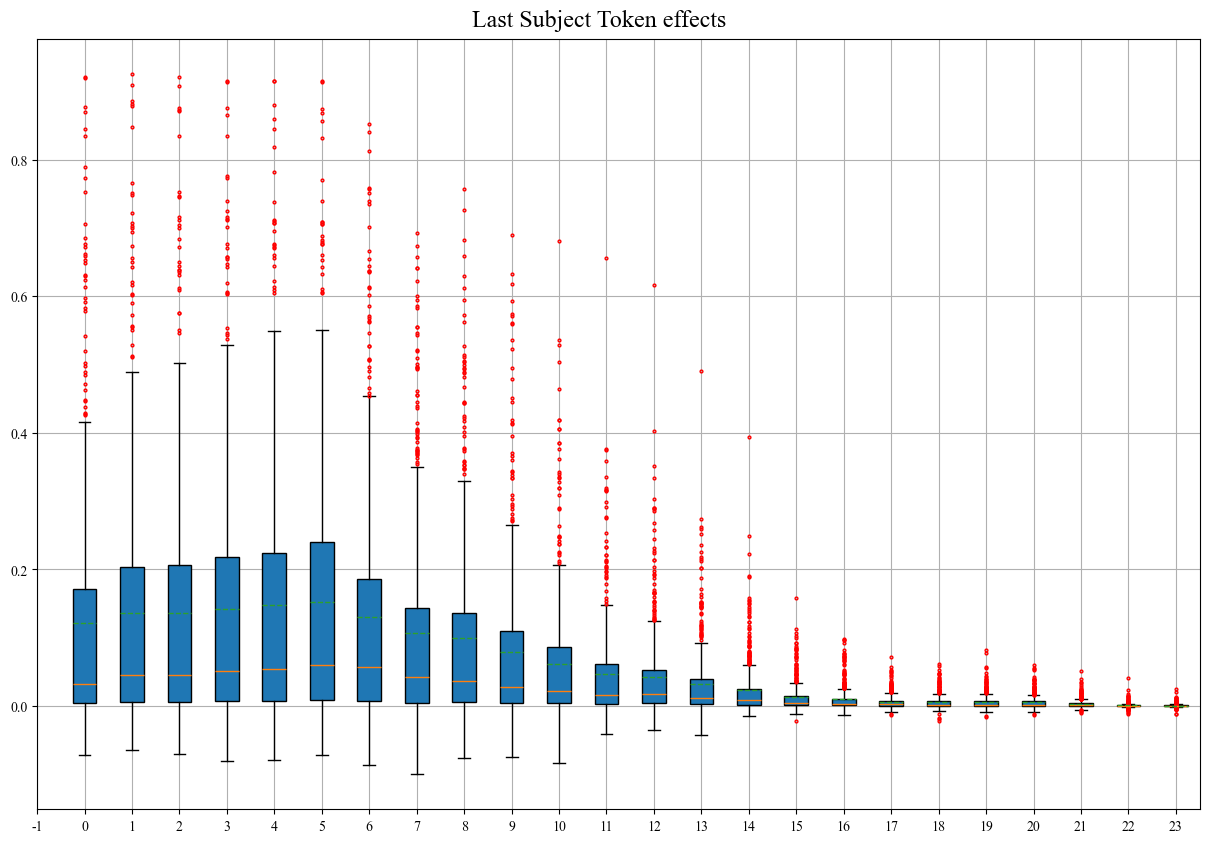

In [93]:
fig = plt.figure(figsize=[15, 10])

fig.suptitle("Last Subject Token effects", y=0.91, fontsize='xx-large')

plt.grid()

flierprops = dict(marker='o', markersize=2, linestyle='none', markeredgecolor='r')

all_boxplots = plt.boxplot(computed_scores['mlp']['last_subject_data'], 
                           patch_artist=True, 
                           vert=True, 
                           meanline=True, 
                           showmeans=True,
                           flierprops=flierprops)

# colors = ['pink', 'lightblue', 'lightgreen', 'lightyellow'][::-1]

# all_boxes = all_boxplots['boxes']

# for i, which_box in enumerate(all_boxes):
#     which_box.set_facecolor(colors[i % 4])

    

# plt.yticks(range(4, correlation_df.shape[0] + 1, 4), correlation_df.iloc[::4]['query'])
plt.xticks(numpy.arange(0, 25), numpy.arange(-1, 24))

plt.show()

## Plot line graph

To make confidence intervals visible, we plot the data as line graphs below.

In [ ]:
import math

labels = [
    "First subject token",
    "Middle subject tokens",
    "Last subject token",
    "First subsequent token",
    "Further tokens",
    "Last token",
]
color_order = [0, 1, 2, 4, 5, 3]
x = None

cmap = plt.get_cmap("tab10")
fig, axes = plt.subplots(1, 3, figsize=(13, 3.5), sharey=True, dpi=200)
for j, (kind, title) in enumerate(
    [
        (None, "single hidden vector"),
        ("mlp", "run of 10 MLP lookups"),
        ("attn", "run of 10 Attn modules"),
    ]
):
    print(f"Reading {kind}")
    d = read_knowlege(225, kind, arch)
    for i, label in list(enumerate(labels)):
        y = d["result"][i] - d["low_score"]
        if x is None:
            x = list(range(len(y)))
        std = d["result_std"][i]
        error = std * 1.96 / math.sqrt(count)
        axes[j].fill_between(
            x, y - error, y + error, alpha=0.3, color=cmap.colors[color_order[i]]
        )
        axes[j].plot(x, y, label=label, color=cmap.colors[color_order[i]])

    axes[j].set_title(f"Average indirect effect of a {title}")
    axes[j].set_ylabel("Average indirect effect on p(o)")
    axes[j].set_xlabel(f"Layer number in {archname}")
    # axes[j].set_ylim(0.1, 0.3)
axes[1].legend(frameon=False)
plt.tight_layout()
plt.savefig(f"results/{arch}/causal_trace/summary_pdfs/lineplot-causaltrace.pdf")
plt.show()